
<center>
  <h1>Graph Machine Learning Project</h1>
  <h2>CentraleSupélec</h2>
  <h3>Alae Taoudi - Mohammed Sbaihi - Ouissal Boutouatou</h3>
</center>

We choose to work on the Cora dataset, which is a co-citation network of scientific publications. Each node represents a publication, the presence of an edge between two nodes indicates that the two papers are co-cited by other papers. The dataset contains 2708 scientific publications (nodes) and 5278 edges (undirected). We plan to use this graph on the link level task of predicting whether two papers are likely to be co-cited based on their content and the structure of the graph (link prediction task). Each node contain textual information (title and abstract of the paper) that we will encode using a pre-trained language model (RoBERTa) to obtain meaningful vector representations (embeddings) of size 1024. These embeddings will be used as features to create node representations that capture both the textual content and the graph structure. <br>

Also note that each publication belongs to one of seven classes. But in this project, we will focus on the link prediction task rather than node classification.

## 1. Loading the graph dataset

In [1]:
import torch
import torch_geometric as pyg
from torch_geometric.datasets import Planetoid

path = "data/cora.pt"
data = torch.load(path, weights_only=False)
text = data.raw_text

# we don't need label names for now
label_names = data.label_names

# nodes already have features (tensors), we should create new node features using raw_text
print(f"Number of features per node : {data.num_node_features}")

# let's see the first node's text
print(f"Node 0 text : {text[0]}")


Number of features per node : 384
Node 0 text :  Stochastic pro-positionalization of non-determinate background knowledge. : It is a well-known fact that propositional learning algorithms require "good" features to perform well in practice. So a major step in data engineering for inductive learning is the construction of good features by domain experts. These features often represent properties of structured objects, where a property typically is the occurrence of a certain substructure having certain properties. To partly automate the process of "feature engineering", we devised an algorithm that searches for features which are defined by such substructures. The algorithm stochastically conducts a top-down search for first-order clauses, where each clause represents a binary feature. It differs from existing algorithms in that its search is not class-blind, and that it is capable of considering clauses ("context") of almost arbitrary length (size). Preliminary experiments are favorabl

## 2. Graph Analytics

### 2.1 Basic Graph Statistics

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from torch_geometric.utils import to_networkx
import warnings
warnings.filterwarnings('ignore')

# -- style config
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# -- convert PyTorch Geometric data to NetworkX graph for analysis
# -- make a copy to avoid modifying the original data
data_copy = data.clone()
G = to_networkx(data_copy, to_undirected=True)
print(f"Graph converted to NetworkX: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph converted to NetworkX: 2708 nodes, 5278 edges


In [4]:
# -- compute basic statistics
stats = {
    'graph_name': 'Cora Co-citation Network',
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'density': nx.density(G),
    'is_connected': nx.is_connected(G),
    'num_components': nx.number_connected_components(G)
}

# -- check if graph is directed or undirected
print("=== Basic Graph Properties ===")
print(f"Graph type: {'Undirected' if isinstance(G, nx.Graph) else 'Directed'}")
print(f"Number of nodes: {stats['num_nodes']}")
print(f"Number of edges: {stats['num_edges']}")
print(f"Graph density: {stats['density']:.6f}")
print(f"Is connected: {stats['is_connected']}")
print(f"Number of connected components: {stats['num_components']}")

if stats['is_connected']:
    diameter = nx.diameter(G)
    avg_path_length = nx.average_shortest_path_length(G)
    print(f"Graph diameter: {diameter}")
    print(f"Average shortest path length: {avg_path_length:.3f}")
else:
    # -- analyze largest component
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    diameter = nx.diameter(G_largest)
    avg_path_length = nx.average_shortest_path_length(G_largest)
    print(f"\nLargest component has {len(largest_cc)} nodes")
    print(f"Diameter (largest component): {diameter}")
    print(f"Average shortest path length (largest component): {avg_path_length:.3f}")

=== Basic Graph Properties ===
Graph type: Undirected
Number of nodes: 2708
Number of edges: 5278
Graph density: 0.001440
Is connected: False
Number of connected components: 78

Largest component has 2485 nodes
Diameter (largest component): 19
Average shortest path length (largest component): 6.311



Degree Statistics:
Average degree: 3.90
Median degree: 3
Min degree: 1
Max degree: 168
Std deviation: 5.23


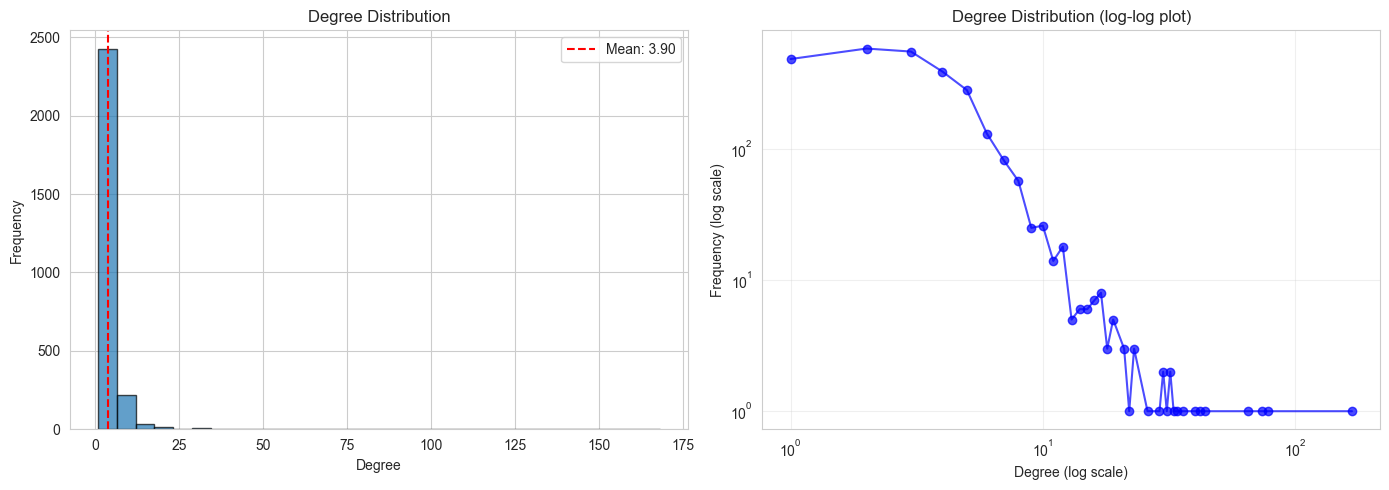

In [5]:
# -- degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())
degree_dist = Counter(degree_values)

print(f"\nDegree Statistics:")
print(f"Average degree: {np.mean(degree_values):.2f}")
print(f"Median degree: {np.median(degree_values):.0f}")
print(f"Min degree: {min(degree_values)}")
print(f"Max degree: {max(degree_values)}")
print(f"Std deviation: {np.std(degree_values):.2f}")

# -- plot degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -- histogram
axes[0].hist(degree_values, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution')
axes[0].axvline(np.mean(degree_values), color='red', linestyle='--', label=f'Mean: {np.mean(degree_values):.2f}')
axes[0].legend()

# -- log-log plot to check for power law
degree_counts = sorted(degree_dist.items())
degrees_x = [d[0] for d in degree_counts]
counts_y = [d[1] for d in degree_counts]
axes[1].loglog(degrees_x, counts_y, 'bo-', alpha=0.7)
axes[1].set_xlabel('Degree (log scale)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Degree Distribution (log-log plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Centrality Measures Analysis

#### 2.2.1 Degree Centrality

In [6]:
# -- degree centrality
degree_cent = nx.degree_centrality(G)
print("Top 10 nodes by Degree Centrality:")
for node, cent in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {cent:.4f} (degree: {G.degree(node)})")

Top 10 nodes by Degree Centrality:
  Node 1686: 0.0621 (degree: 168)
  Node 2177: 0.0288 (degree: 78)
  Node 1016: 0.0273 (degree: 74)
  Node 1634: 0.0240 (degree: 65)
  Node 2628: 0.0163 (degree: 44)
  Node 753: 0.0155 (degree: 42)
  Node 1834: 0.0148 (degree: 40)
  Node 1635: 0.0133 (degree: 36)
  Node 962: 0.0126 (degree: 34)
  Node 1270: 0.0122 (degree: 33)


#### 2.2.2 Eigenvector Centrality

In [7]:
# -- eigenvector centrality
try:
    eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
    print("Top 10 nodes by Eigenvector Centrality:")
    for node, cent in sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  Node {node}: {cent:.4f}")
except:
    print("Eigenvector centrality computation failed (graph may not be connected)")
    eigenvector_cent = None

Top 10 nodes by Eigenvector Centrality:
  Node 1686: 0.6543
  Node 2563: 0.1179
  Node 2583: 0.0992
  Node 1316: 0.0918
  Node 2611: 0.0914
  Node 1153: 0.0903
  Node 949: 0.0871
  Node 1548: 0.0855
  Node 2571: 0.0770
  Node 1690: 0.0748


#### 2.2.3 PageRank Centrality

In [8]:
# -- PageRank centrality
pagerank_cent = nx.pagerank(G, alpha=0.85)
print("Top 10 nodes by PageRank:")
for node, cent in sorted(pagerank_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {cent:.4f}")

Top 10 nodes by PageRank:
  Node 1686: 0.0122
  Node 1016: 0.0063
  Node 1634: 0.0054
  Node 2177: 0.0051
  Node 2628: 0.0036
  Node 1834: 0.0032
  Node 753: 0.0028
  Node 1635: 0.0027
  Node 1270: 0.0026
  Node 962: 0.0025


#### 2.2.4 Betweenness Centrality

In [9]:
# -- betweenness centrality
betweenness_cent = nx.betweenness_centrality(G)
print("Top 10 nodes by Betweenness Centrality:")
for node, cent in sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {cent:.4f}")

Top 10 nodes by Betweenness Centrality:
  Node 1686: 0.2325
  Node 1634: 0.1261
  Node 1834: 0.0893
  Node 1016: 0.0853
  Node 2177: 0.0764
  Node 2611: 0.0679
  Node 962: 0.0632
  Node 2628: 0.0525
  Node 1635: 0.0498
  Node 2178: 0.0413


#### 2.2.5 Closeness Centrality

In [10]:
# -- closeness centrality
if nx.is_connected(G):
    closeness_cent = nx.closeness_centrality(G)
    print("Top 10 nodes by Closeness Centrality:")
    for node, cent in sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  Node {node}: {cent:.4f}")
else:
    print("Graph is not connected, computing closeness on largest component")
    largest_cc = max(nx.connected_components(G), key=len)
    G_cc = G.subgraph(largest_cc).copy()
    closeness_cent = nx.closeness_centrality(G_cc)
    print(f"\nTop 10 nodes by Closeness Centrality (largest component with {len(largest_cc)} nodes):")
    for node, cent in sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  Node {node}: {cent:.4f}")

Graph is not connected, computing closeness on largest component

Top 10 nodes by Closeness Centrality (largest component with 2485 nodes):
  Node 1686: 0.2428
  Node 2177: 0.2410
  Node 1634: 0.2396
  Node 2611: 0.2354
  Node 1864: 0.2353
  Node 2178: 0.2325
  Node 962: 0.2315
  Node 2173: 0.2276
  Node 1834: 0.2263
  Node 41: 0.2260


#### 2.2.6 Clustering Coefficient

In [11]:
# -- clustering coefficients
clustering_coef = nx.clustering(G)
avg_clustering = nx.average_clustering(G)

print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
print("\nTop 10 nodes by Clustering Coefficient:")
for node, coef in sorted(clustering_coef.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  Node {node}: {coef:.4f}")

Average Clustering Coefficient: 0.2407

Top 10 nodes by Clustering Coefficient:
  Node 21: 1.0000
  Node 24: 1.0000
  Node 46: 1.0000
  Node 50: 1.0000
  Node 63: 1.0000
  Node 70: 1.0000
  Node 76: 1.0000
  Node 89: 1.0000
  Node 90: 1.0000
  Node 98: 1.0000


#### 2.2.7 Compare Centrality Measures

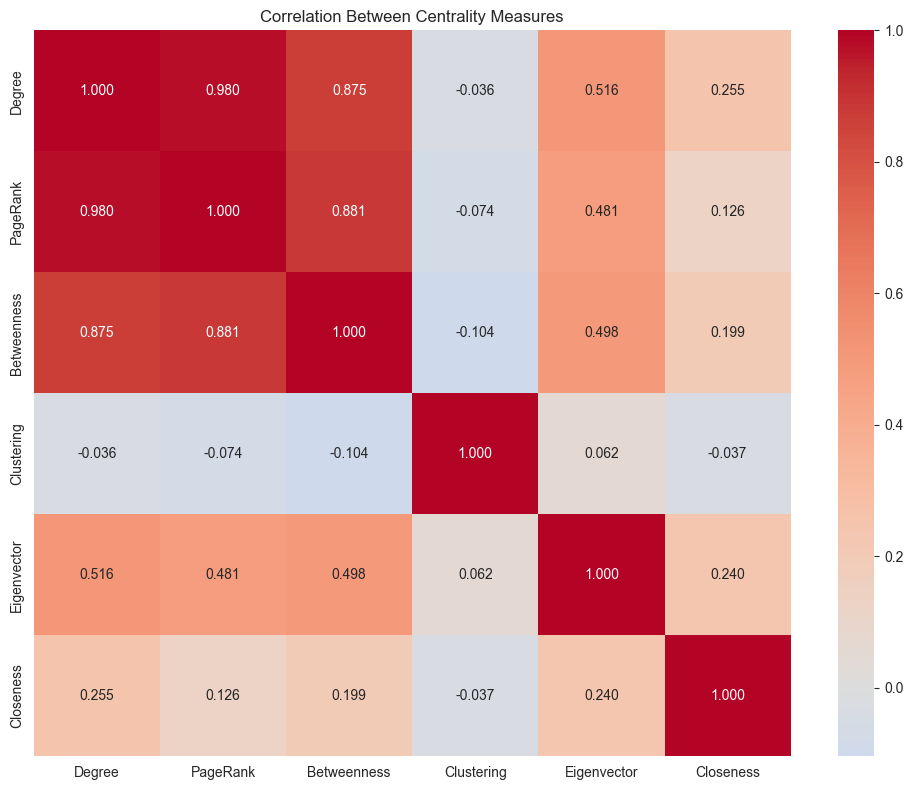

In [12]:
# -- dataframe with all centrality measures
centrality_df = pd.DataFrame({
    'Degree': degree_cent,
    'PageRank': pagerank_cent,
    'Betweenness': betweenness_cent,
    'Clustering': clustering_coef
})

if eigenvector_cent:
    centrality_df['Eigenvector'] = pd.Series(eigenvector_cent)

if not nx.is_connected(G):
    # -- for closeness, fill missing values with 0
    closeness_full = {node: 0 for node in G.nodes()}
    closeness_full.update(closeness_cent)
    centrality_df['Closeness'] = pd.Series(closeness_full)
else:
    centrality_df['Closeness'] = pd.Series(closeness_cent)

# -- correlation between centrality measures
plt.figure(figsize=(10, 8))
sns.heatmap(centrality_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Between Centrality Measures')
plt.tight_layout()
plt.show()

## 3. Node Embeddings

## 3.1 Text Embeddings

### 3.1.1 Enocding nodes texts using RoBERTa
We use the RoBERTa model to encode the nodes texts to embeddings of size 1024. We will use the HuggingFace Inference API to encode the texts in batches without having to load and run the model locally. This requires an HF token. You can generate one for free on your HuggingFace account. We ran the encoding using a PRO account to benefit from higher rate limits. But the free account should be sufficient for encoding the Cora dataset.

In [41]:
# import os

# # -- load HF token to use inference client instead of running the model locally
# from dotenv import load_dotenv
# load_dotenv()
# hf_token = os.getenv("HF_TOKEN")

In [15]:
# # we have 2708 nodes, we need to batch the encoding to avoid memory issues
# from huggingface_hub import InferenceClient
# from tqdm import tqdm
# import torch

# MODEL_NAME = "sentence-transformers/all-roberta-large-v1"
# BATCH_SIZE = 64

# client = InferenceClient(
#     provider="hf-inference",
#     api_key=hf_token,
# )


# def batch_encode(texts, model, batch_size=64):
#     """
#     Encode a list of texts using a sentence transformer model via HuggingFace Inference API.
    
#     Args:
#         texts: List of strings (title and abstract of papers) to encode
#         model: Name of the model to use
#         batch_size: Number of texts to encode in each batch
    
#     Returns:
#         torch.Tensor: Embeddings tensor of shape (len(texts), embedding_dim)
#     """
#     embeddings = []
#     num_batches = (len(texts) + batch_size - 1) // batch_size  # ceiling division
    
#     for i in tqdm(range(0, len(texts), batch_size), 
#                   desc="Encoding batches", 
#                   total=num_batches):
#         batch_texts = texts[i:i+batch_size]
#         batch_embeddings = client.feature_extraction(
#             text=batch_texts,
#             model=model,
#         ) # returns a list of arrays
#         batch_embeddings = torch.tensor(batch_embeddings)
#         embeddings.append(batch_embeddings)
    
#     return torch.cat(embeddings, dim=0)


# embeddings = batch_encode(text, MODEL_NAME, BATCH_SIZE)
# print(f"Embeddings shape: {embeddings.shape}")

In [16]:
# # -- let's save the embeddings
# torch.save(embeddings, "data/cora_embeddings.pt")

# # -- we can also replace the existing node features with the new embeddings
# data.x = embeddings

In [13]:
# -- load embeddings

embeddings = torch.load("data/cora_embeddings.pt", weights_only=True)
data.x = embeddings

### 3.1.2 Text Embedding Quality Analysis
Before using the embeddings to generate node representations, we want to make sure that the embeddings capture the semantic similarity between the papers. We can do this by visualizing the embeddings in 2D space using t-SNE and coloring the points based on their classes. If the embeddings are good, we should see that papers from the same class are clustered together (assuming the classes are semantically meaningful).

Note that we only use the classes for visualization purposes, not for training or evaluation.

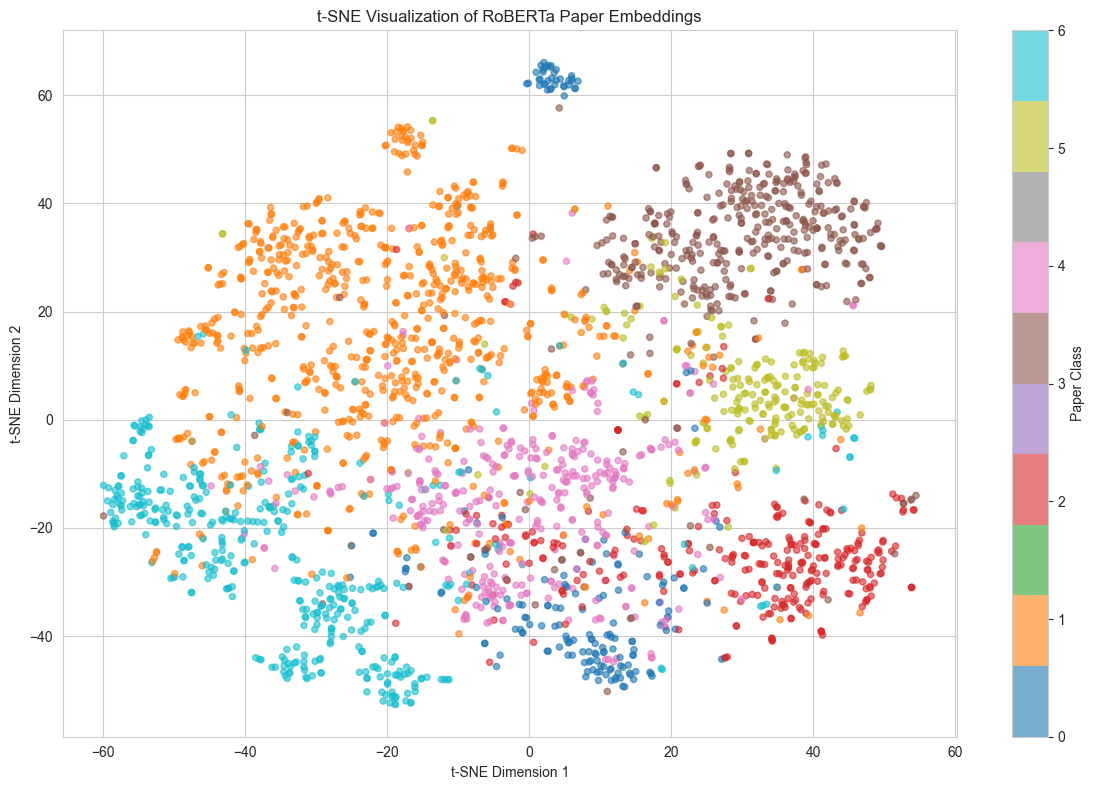

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# -- reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# -- color by class labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=data.y.numpy(), cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='Paper Class')
plt.title('t-SNE Visualization of RoBERTa Paper Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

### 3.1.3 Graph-Content Correlation Analysis
Once we confirmed that the text embeddings are of good quality, we naturally want to check if there is a correlation between the graph structure and the content of the papers. In other words, do papers that are connected in the graph (co-cited) have similar content (embeddings)? To do so, we measure the similarity between the embeddings of connected nodes and compare it to the similarity between non-connected nodes. We can use cosine similarity as a measure of similarity between normalized embeddings.

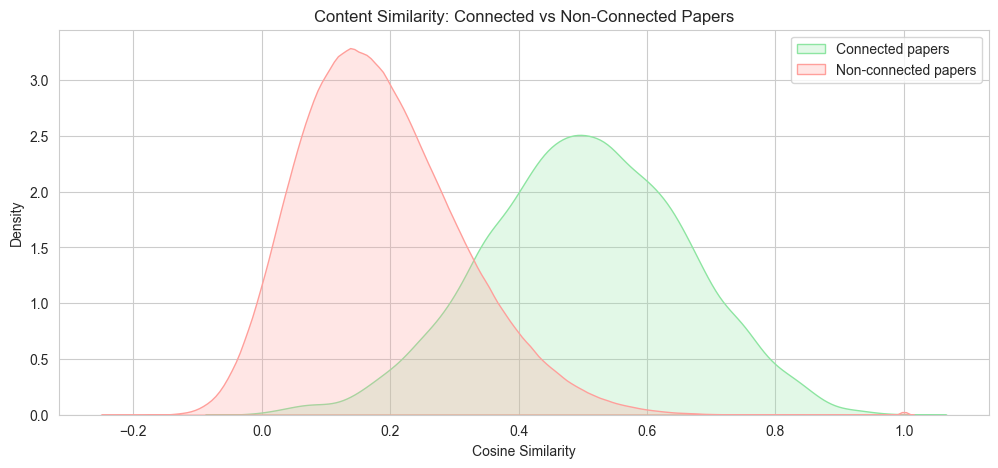

Mean similarity (connected): 0.503
Mean similarity (non-connected): 0.186


In [15]:
from torch_geometric.utils import to_dense_adj
import seaborn as sns
normalized_embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

# -- create adjacency matrix
adj_matrix = to_dense_adj(data.edge_index)[0]

# -- compute cosine similarity matrix
similarity_matrix = normalized_embeddings @ normalized_embeddings.T

# -- extract similarities for connected and non-connected pairs
connected_pairs = adj_matrix.nonzero(as_tuple=True)
non_connected_pairs = (1 - adj_matrix).nonzero(as_tuple=True)
connected_similarities = similarity_matrix[connected_pairs].cpu().numpy()
non_connected_similarities = similarity_matrix[non_connected_pairs].cpu().numpy()

# -- plot distributions using seaborn
colors = sns.color_palette("pastel", 10)




plt.figure(figsize=(12, 5))
sns.kdeplot(connected_similarities, label='Connected papers', fill=True, color=colors[2])
sns.kdeplot(non_connected_similarities, label='Non-connected papers', fill=True, color=colors[3])
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Content Similarity: Connected vs Non-Connected Papers')
plt.legend()
plt.show()

print(f"Mean similarity (connected): {connected_similarities.mean():.3f}")
print(f"Mean similarity (non-connected): {non_connected_similarities.mean():.3f}")

We can observe that the connected papers tend to have higher content similarity compared to non-connected papers. This suggests that the graph structure is indeed capturing some aspects of the content similarity between papers. There is also some overlap between the two distributions, we interpret this by the fact that co-cited papers may not always be similar in content, as they could be cited together for other reasons like methodoloy, dataset, etc.

## 3.2 Node Represetations

In [20]:
# # -- load data and embeddings
# import torch
# data = torch.load("data/cora.pt", weights_only=False)
# embeddings = torch.load("data/cora_embeddings.pt", weights_only=True)

# data.x = embeddings

### 3.2.1 Splitting edges into train/val/test
Our graph is undirected, so each edge (u, v) is bidirectional. When splitting the edges into train/val/test sets, we need to make sure that both directions of an edge are in the same set. For example, if (u, v) is in the training set, then (v, u) should also be in the training set. This is important to avoid data leakage during training and evaluation.

In [16]:
from torch_geometric.transforms import RandomLinkSplit


# -- split edges: 80% train, 10% validation, 10% test
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True, # to avoid leakage
    add_negative_train_samples=True,  # generate negative examples for training
    neg_sampling_ratio=1.0,  # to have a balanced train set
    split_labels=True,  # to split pos_edge_label and neg_edge_label tensors
)

train_data, val_data, test_data = transform(data)

In [17]:
print("Split Results:")
print("-"*60)
print(f"Training set:")
print(f"  Number of nodes: {train_data.num_nodes}")
print(f"  Number of edges (Message passing): {train_data.num_edges}")
print(f"  Number of positive training edges: {train_data.pos_edge_label_index.shape[1]}")
print(f"  Number of negative training edges: {train_data.neg_edge_label_index.shape[1]}")
print(f"  Split ratio: {100*train_data.edge_index.shape[1] / data.edge_index.shape[1]:.1f}%")
print("-"*60)
print(f"Validation set:")
print(f"  Number of nodes: {val_data.num_nodes}")
print(f"  Number of edges (Message passing): {val_data.num_edges}")
print(f"  Number of positive validation edges: {val_data.pos_edge_label_index.shape[1]}")
print(f"  Split ratio: {100*2*val_data.pos_edge_label_index.shape[1] / data.edge_index.shape[1]:.1f}%")
print("-"*60)
print(f"Test set:")
print(f"  Number of nodes: {test_data.num_nodes}")
print(f"  Number of edges (Message passing): {test_data.num_edges}")
print(f"  Number of positive test edges: {test_data.pos_edge_label_index.shape[1]}")
print(f"  Split ratio: {100*2*test_data.pos_edge_label_index.shape[1] / data.edge_index.shape[1]:.1f}%")
print("-"*60)

Split Results:
------------------------------------------------------------
Training set:
  Number of nodes: 2708
  Number of edges (Message passing): 8690
  Number of positive training edges: 4345
  Number of negative training edges: 4345
  Split ratio: 80.0%
------------------------------------------------------------
Validation set:
  Number of nodes: 2708
  Number of edges (Message passing): 8690
  Number of positive validation edges: 542
  Split ratio: 10.0%
------------------------------------------------------------
Test set:
  Number of nodes: 2708
  Number of edges (Message passing): 9774
  Number of positive test edges: 542
  Split ratio: 10.0%
------------------------------------------------------------


We got almost perfect splits with 80% of edges for training, 10% for validation, and 10% for testing.<br>

Note that the number of edges used for message passing during training is different from the number of edges (positive edges) used for supervision (predicting the presence of an edge). This is normal behavior because message passing edges will be used to model the graph structure (in Aggregation for example) so we need both directions of edges to identify neighbours. While supervision edges will be considered unidirectional for binary classification.<br>

Validation message passing edges are the same as training edges because we can't use validation edges (that we want to predict) during message passing.<br>

Test message passing edges include both training and validation edges because the latter are known during testing (we want to predict test edges only).

### 3.2.2 Method 1 : Neighbor Aggregation

In [18]:
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj

def neighbor_aggregation(x, edge_index, num_hops=2, split_name=""):
    """
    Aggregate neighbor features via multi-hop message passing
    
    Args:
        x: Node features [num_nodes, feature_dim]
        edge_index: Graph edges [2, num_edges]
        num_hops: Number of hops for aggregation
    
    Returns:
        Aggregated embeddings [num_nodes, feature_dim]
    """
    adj = to_dense_adj(edge_index)[0]
    
    # -- we add self-loops (so node keeps its own information)
    adj = adj + torch.eye(adj.shape[0], device=adj.device)
    
    # -- normalize by degree (row normalization)
    degree = adj.sum(dim=1)
    adj_norm = adj / degree.unsqueeze(1)
    
    h = x.clone()
    for hop in range(num_hops):
        h = torch.mm(adj_norm, h)

    print(f"{split_name} embeddings shape: {h.shape}")

    return h

NUM_HOPS = 2
print('-'*60)
print(f"   COMPUTING NEIGHBOR AGGREGATION EMBEDDINGS (NUM_HOPS={NUM_HOPS})")
print('-'*60)

train_emb_agg = neighbor_aggregation(
    train_data.x,
    train_data.edge_index,
    num_hops=NUM_HOPS,
    split_name="Train"
)

val_emb_agg = neighbor_aggregation(
    val_data.x,
    val_data.edge_index,
    num_hops=NUM_HOPS,
    split_name="Validation"
)

test_emb_agg = neighbor_aggregation(
    test_data.x,
    test_data.edge_index,
    num_hops=NUM_HOPS,
    split_name="Test"
)


------------------------------------------------------------
   COMPUTING NEIGHBOR AGGREGATION EMBEDDINGS (NUM_HOPS=2)
------------------------------------------------------------
Train embeddings shape: torch.Size([2708, 1024])
Validation embeddings shape: torch.Size([2708, 1024])
Test embeddings shape: torch.Size([2708, 1024])


### 3.2.2.1 Neighbor Aggregation with Dot Product Scoring
In this method, we use the aggregated embeddings directly to predict the presence of an edge between two nodes using the dot product as a scoring function. We hope that the aggregation captured enough information about the structure of the graph to make accurate predictions.


In [37]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

def predict_edges(embeddings, edge_label_index):
    """
    Predict edge existence using dot product
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        edge_label_index: Edge pairs to predict [2, pos/neg_edge_index]

    Returns:
        Scores for each edge [pos/neg_edge_index]
    """
    src = edge_label_index[0]
    dst = edge_label_index[1]

    src_emb = embeddings[src]
    dst_emb = embeddings[dst]

    # dot product (cosine similarity for normalized embeddings)
    scores = (src_emb * dst_emb).sum(dim=-1)
    
    return scores

def evaluate(embeddings, pos_edge_index, neg_edge_index, split_name=""):
    """
    Evaluate link prediction performance
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        pos_edge_index: Positive edge pairs [2, num_pos_edges]
        neg_edge_index: Negative edge pairs [2, num_neg_edges]
        split_name: Name for printing
    
    Returns:
        Dictionary with metrics
    """
    # -- predict positive and negative edge scores
    pos_scores = predict_edges(embeddings, pos_edge_index)
    neg_scores = predict_edges(embeddings, neg_edge_index)
    
    # -- combine scores and create labels
    scores = torch.cat([pos_scores, neg_scores]).cpu().detach().numpy()
    labels = np.concatenate([
        np.ones(pos_scores.shape[0]),   # 1 for positive edges
        np.zeros(neg_scores.shape[0])   # 0 for negative edges
    ])
    
    # -- metrics
    auc_roc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)
    
    # -- binary predictions (threshold at 0)
    preds = (scores > 0.28).astype(int)
    accuracy = (preds == labels).mean()

    # -- separate positive and negative scores for analysis
    pos_scores_np = pos_scores.cpu().detach().numpy()
    neg_scores_np = neg_scores.cpu().detach().numpy()
    
    # Print results
    print(f"\n{split_name} Results:")
    print(f"  ROC-AUC: {auc_roc:.4f}")
    print(f"  Average Precision: {ap:.4f}")
    print(f"  Accuracy (threshold=0.28): {accuracy:.4f}")
    print(f"  Pos edges - Mean: {pos_scores_np.mean():.4f}, Std: {pos_scores_np.std():.4f}")
    print(f"  Neg edges - Mean: {neg_scores_np.mean():.4f}, Std: {neg_scores_np.std():.4f}")
    print(f"  Separation: {pos_scores_np.mean() - neg_scores_np.mean():.4f}")
    
    return {
        'roc_auc': auc_roc,
        'ap': ap,
        'accuracy': accuracy,
        'pos_mean': pos_scores_np.mean(),
        'neg_mean': neg_scores_np.mean(),
    }




Mean difference (pos - neg) on train set: 0.2325


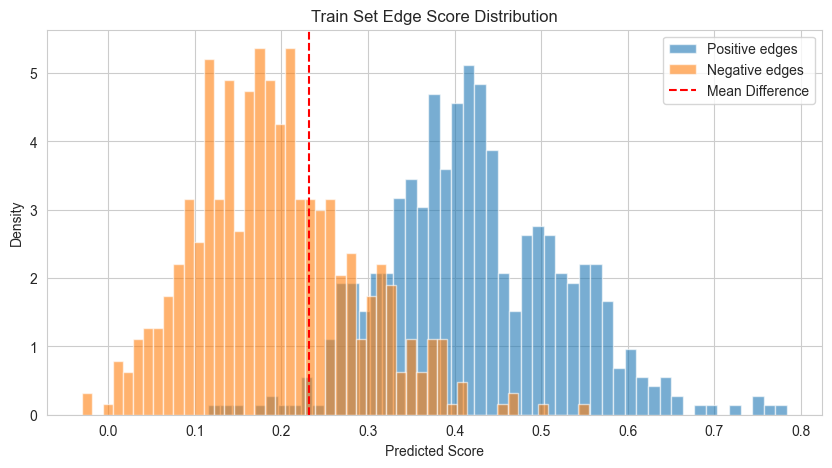

In [21]:
# -- choose the right threshold based on train set scores
import matplotlib.pyplot as plt
# train_pos_scores = predict_edges(train_emb_agg, train_data.pos_edge_label_index)
# train_neg_scores = predict_edges(train_emb_agg, train_data.neg_edge_label_index)

val_pos_scores = predict_edges(val_emb_agg, val_data.pos_edge_label_index)
val_neg_scores = predict_edges(val_emb_agg, val_data.neg_edge_label_index)
mean_difference = val_pos_scores.mean() - val_neg_scores.mean()


# mean_difference = train_pos_scores.mean() - train_neg_scores.mean()
print(f"\nMean difference (pos - neg) on train set: {mean_difference:.4f}")

# -- visualize score distributions to choose threshold (mean difference)
plt.figure(figsize=(10, 5))
# plt.hist(train_pos_scores.cpu().numpy(), bins=50, alpha=0.6, label='Positive edges', density=True)
# plt.hist(train_neg_scores.cpu().numpy(), bins=50, alpha=0.6, label='Negative edges', density=True)
plt.hist(val_pos_scores.cpu().numpy(), bins=50, alpha=0.6, label='Positive edges', density=True)
plt.hist(val_neg_scores.cpu().numpy(), bins=50, alpha=0.6, label='Negative edges', density=True)
plt.axvline(x=mean_difference, color='r', linestyle='--', label='Mean Difference')
plt.xlabel('Predicted Score')
plt.ylabel('Density')
plt.title('Train Set Edge Score Distribution')
plt.legend()
plt.show()

In [22]:
print("\n" + '-' * 70)
print("EVALUATION")
print('-' * 70)

# Training set
train_results = evaluate(
    train_emb_agg,
    train_data.pos_edge_label_index,
    train_data.neg_edge_label_index,
    split_name="TRAINING SET"
)

# Validation set
val_results = evaluate(
    val_emb_agg,
    val_data.pos_edge_label_index,
    val_data.neg_edge_label_index,
    split_name="VALIDATION SET"
)

# Test set
test_results = evaluate(
    test_emb_agg,
    test_data.pos_edge_label_index,
    test_data.neg_edge_label_index,
    split_name="TEST SET"
)

results_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_results['roc_auc'], val_results['roc_auc'], test_results['roc_auc']],
    'AP': [train_results['ap'], val_results['ap'], test_results['ap']],
    'Accuracy': [train_results['accuracy'], val_results['accuracy'], test_results['accuracy']],
})

print("\n" + '-' * 70)
print("RESULTS SUMMARY")
print('-' * 70)
print(results_df)

results_df.to_csv("results/neighbor_aggregation_results.csv", index=False)


----------------------------------------------------------------------
EVALUATION
----------------------------------------------------------------------

TRAINING SET Results:
  ROC-AUC: 0.9847
  Average Precision: 0.9826
  Accuracy (threshold=0.28): 0.9154
  Pos edges - Mean: 0.4754, Std: 0.1035
  Neg edges - Mean: 0.1888, Std: 0.0915
  Separation: 0.2866

VALIDATION SET Results:
  ROC-AUC: 0.9548
  Average Precision: 0.9516
  Accuracy (threshold=0.28): 0.8865
  Pos edges - Mean: 0.4244, Std: 0.1027
  Neg edges - Mean: 0.1919, Std: 0.0910
  Separation: 0.2325

TEST SET Results:
  ROC-AUC: 0.9554
  Average Precision: 0.9516
  Accuracy (threshold=0.28): 0.8875
  Pos edges - Mean: 0.4203, Std: 0.1013
  Neg edges - Mean: 0.1937, Std: 0.0917
  Separation: 0.2266

----------------------------------------------------------------------
RESULTS SUMMARY
----------------------------------------------------------------------
        Split   ROC-AUC        AP  Accuracy
0       Train  0.984732  0.

### 3.2.2.2 Neighbor Aggregation with Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch


def create_edge_dataset(embeddings, pos_edge_index, neg_edge_index):
    """
    Create tabular dataset by concatenating node embeddings for each edge
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        pos_edge_index: Positive edges [2, num_pos]
        neg_edge_index: Negative edges [2, num_neg]
    
    Returns:
        X: Feature matrix [num_edges, 2*embedding_dim]
        y: Labels [num_edges] (1 for positive, 0 for negative)
    """
    pos_src = pos_edge_index[0].cpu().numpy()
    pos_dst = pos_edge_index[1].cpu().numpy()

    neg_src = neg_edge_index[0].cpu().numpy()
    neg_dst = neg_edge_index[1].cpu().numpy()

    emb_np = embeddings.cpu().detach().numpy() 
    
    pos_features = np.concatenate([
        emb_np[pos_src],
        emb_np[pos_dst]
    ], axis=1)
    
    neg_features = np.concatenate([
        emb_np[neg_src],
        emb_np[neg_dst]
    ], axis=1)
    
    X = np.vstack([pos_features, neg_features])
    y = np.hstack([
        np.ones(len(pos_src)),   # 1 for positive
        np.zeros(len(neg_src))   # 0 for negative
    ])
    
    return X, y


print('-' * 70)
print("CREATING TABULAR DATASETS FOR LOGISTIC REGRESSION")
print('-' * 70)

# Training set
X_train, y_train = create_edge_dataset(
    train_emb_agg,
    train_data.pos_edge_label_index,
    train_data.neg_edge_label_index
)

# Validation set
X_val, y_val = create_edge_dataset(
    val_emb_agg,
    val_data.pos_edge_label_index,
    val_data.neg_edge_label_index
)

# Test set
X_test, y_test = create_edge_dataset(
    test_emb_agg,
    test_data.pos_edge_label_index,
    test_data.neg_edge_label_index
)

print(f"\nDataset shapes:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")
print(f"  Feature dimension: {X_train.shape[1]} (2 × {X_train.shape[1]//2})")

----------------------------------------------------------------------
CREATING TABULAR DATASETS FOR LOGISTIC REGRESSION
----------------------------------------------------------------------

Dataset shapes:
  Train: X=(8690, 2048), y=(8690,)
  Val:   X=(1084, 2048), y=(1084,)
  Test:  X=(1084, 2048), y=(1084,)
  Feature dimension: 2048 (2 × 1024)


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("\n" + '-' * 70)
print("TRAINING LOGISTIC REGRESSION")
print('-' * 70)


lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
)

lr_model.fit(X_train_scaled, y_train)



----------------------------------------------------------------------
TRAINING LOGISTIC REGRESSION
----------------------------------------------------------------------


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [25]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, classification_report

def evaluate_lr(model, X, y, scaler, split_name=""):
    """Evaluate logistic regression model"""
    y_pred_proba = model.predict_proba(X)[:, 1]  
    # y_pred = model.predict(X)
    
    THRESHOLD = 0.48
    y_pred = (y_pred_proba >= THRESHOLD).astype(int)

    auc = roc_auc_score(y, y_pred_proba)
    ap = average_precision_score(y, y_pred_proba)
    acc = accuracy_score(y, y_pred)
    
    print(f"\n{split_name} Results:")
    print(f"  ROC-AUC: {auc:.4f}")
    print(f"  AP: {ap:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"\n{split_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Edge', 'Edge']))
    
    return {
        'roc_auc': auc,
        'ap': ap,
        'accuracy': acc,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred
    }

print("\n" + '-' * 70)
print("EVALUATION")
print('-' * 70)

train_lr_results = evaluate_lr(lr_model, X_train_scaled, y_train, scaler, "TRAINING SET")
val_lr_results = evaluate_lr(lr_model, X_val_scaled, y_val, scaler, "VALIDATION SET")
test_lr_results = evaluate_lr(lr_model, X_test_scaled, y_test, scaler, "TEST SET")

results_lr_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_lr_results['roc_auc'], val_lr_results['roc_auc'], test_lr_results['roc_auc']],
    'AP': [train_lr_results['ap'], val_lr_results['ap'], test_lr_results['ap']],
    'Accuracy': [train_lr_results['accuracy'], val_lr_results['accuracy'], test_lr_results['accuracy']],
})

print("\n" + '-' * 70)
print("RESULTS SUMMARY")
print('-' * 70)
print(results_lr_df)

results_lr_df.to_csv("results/logistic_regression_results.csv", index=False)



----------------------------------------------------------------------
EVALUATION
----------------------------------------------------------------------

TRAINING SET Results:
  ROC-AUC: 0.8373
  AP: 0.8262
  Accuracy: 0.7588

TRAINING SET Classification Report:
              precision    recall  f1-score   support

     No Edge       0.79      0.71      0.75      4345
        Edge       0.74      0.81      0.77      4345

    accuracy                           0.76      8690
   macro avg       0.76      0.76      0.76      8690
weighted avg       0.76      0.76      0.76      8690


VALIDATION SET Results:
  ROC-AUC: 0.5811
  AP: 0.5549
  Accuracy: 0.5683

VALIDATION SET Classification Report:
              precision    recall  f1-score   support

     No Edge       0.58      0.49      0.53       542
        Edge       0.56      0.65      0.60       542

    accuracy                           0.57      1084
   macro avg       0.57      0.57      0.57      1084
weighted avg       0.57

### 3.2.3 Method 2 : Node2Vec + Text Embeddings

In [26]:
from torch_geometric.typing import WITH_PYG_LIB, WITH_TORCH_CLUSTER

In [27]:
WITH_TORCH_CLUSTER

True

In [46]:
# Node2Vec 
import torch
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

EMBEDDING_DIM = 128
WALK_LENGTH = 20
CONTEXT_SIZE = 10
WALKS_PER_NODE = 10
NUM_NEGATIVE_SAMPLES = 1

model = Node2Vec(
    edge_index=train_data.edge_index,
    embedding_dim=EMBEDDING_DIM,
    walk_length=WALK_LENGTH,
    context_size=CONTEXT_SIZE,
    walks_per_node=WALKS_PER_NODE,
    num_negative_samples=NUM_NEGATIVE_SAMPLES,
    sparse=False
).to('cpu')

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    return model.embedding.weight.cpu()
print("\n" + '-' * 70)
print("TRAINING NODE2VEC MODEL")
print('-' * 70)

for epoch in range(1, 200):
    loss = train()
    print(f"Epoch {epoch}: Loss = {loss:.4f}")
node2vec_embeddings = test()
print(f"Node2Vec embeddings shape: {node2vec_embeddings.shape}")


COLORS = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = train_data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(len(train_data.label_names)):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()



----------------------------------------------------------------------
TRAINING NODE2VEC MODEL
----------------------------------------------------------------------
Epoch 1: Loss = 7.8648
Epoch 2: Loss = 5.8273
Epoch 3: Loss = 4.8114
Epoch 4: Loss = 4.0423
Epoch 5: Loss = 3.4283
Epoch 6: Loss = 2.9393
Epoch 7: Loss = 2.5357
Epoch 8: Loss = 2.2110
Epoch 9: Loss = 1.9504
Epoch 10: Loss = 1.7383
Epoch 11: Loss = 1.5674
Epoch 12: Loss = 1.4292
Epoch 13: Loss = 1.3167
Epoch 14: Loss = 1.2279
Epoch 15: Loss = 1.1554
Epoch 16: Loss = 1.0999
Epoch 17: Loss = 1.0503
Epoch 18: Loss = 1.0149
Epoch 19: Loss = 0.9845
Epoch 20: Loss = 0.9585
Epoch 21: Loss = 0.9381
Epoch 22: Loss = 0.9228
Epoch 23: Loss = 0.9097
Epoch 24: Loss = 0.8967
Epoch 25: Loss = 0.8842
Epoch 26: Loss = 0.8770
Epoch 27: Loss = 0.8694
Epoch 28: Loss = 0.8625
Epoch 29: Loss = 0.8568
Epoch 30: Loss = 0.8514
Epoch 31: Loss = 0.8475
Epoch 32: Loss = 0.8429
Epoch 33: Loss = 0.8398
Epoch 34: Loss = 0.8365
Epoch 35: Loss = 0.8337
Ep

In [49]:
# -- let's save the embeddings
torch.save(node2vec_embeddings, "data/node2vec_embeddings.pt")

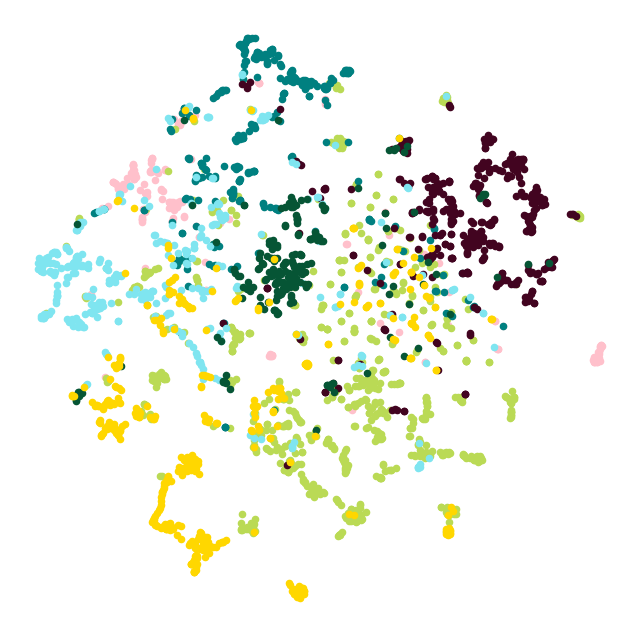

In [47]:
# -- visualize Node2Vec embeddings using t-SNE
plot_points(COLORS)

#### Combining Node2Vec with Text Embeddings
Node2Vec captures the graph structure (random walk-based neighborhood), while RoBERTa embeddings capture the semantic content of papers. By concatenating both, we create joint representations that encode both structural and content information. This should improve link prediction since co-citation depends on both factors.

Node2Vec embeddings shape: torch.Size([2708, 128])
Text embeddings shape: torch.Size([2708, 1024])
Combined embeddings shape: torch.Size([2708, 1152])


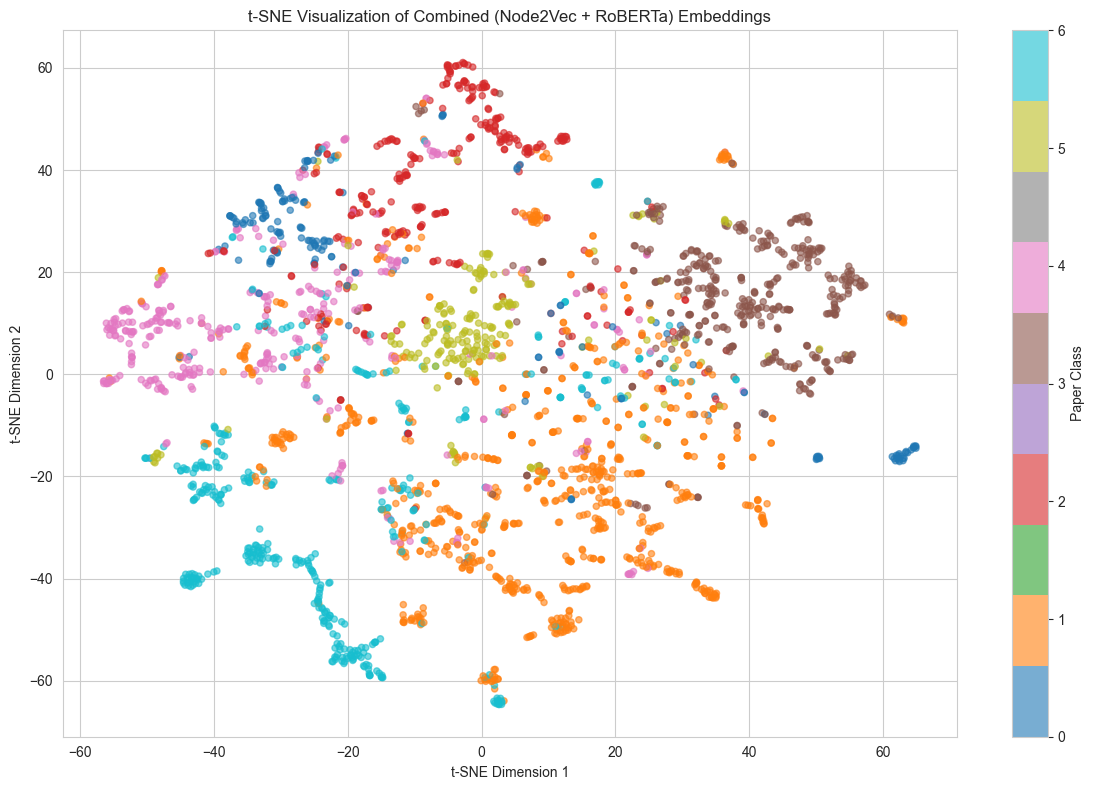

In [ ]:
# -- combine Node2Vec structural embeddings with RoBERTa text embeddings
# Node2Vec: [2708, 128] (graph structure)
# RoBERTa:  [2708, 1024] (text content)
# Combined: [2708, 1152]


combined_embeddings = torch.cat([node2vec_embeddings, embeddings], dim=1)
print(f"Node2Vec embeddings shape: {node2vec_embeddings.shape}")
print(f"Text embeddings shape: {embeddings.shape}")
print(f"Combined embeddings shape: {combined_embeddings.shape}")

# -- visualize combined embeddings using t-SNE
tsne_combined = TSNE(n_components=2, random_state=42, perplexity=30)
combined_2d = tsne_combined.fit_transform(combined_embeddings.detach().numpy())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(combined_2d[:, 0], combined_2d[:, 1],
                     c=data.y.numpy(), cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='Paper Class')
plt.title('t-SNE Visualization of Combined (Node2Vec + RoBERTa) Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

#### 3.2.3.1 Node2Vec + Text Embeddings with Dot Product Scoring
We evaluate the combined embeddings using the same dot product scoring approach as in Method 1. Since the combined embeddings are not aggregated via message passing, the dot product directly measures the similarity between the joint (structure + content) representations of node pairs.


----------------------------------------------------------------------
NODE2VEC + TEXT EMBEDDINGS - DOT PRODUCT EVALUATION
----------------------------------------------------------------------


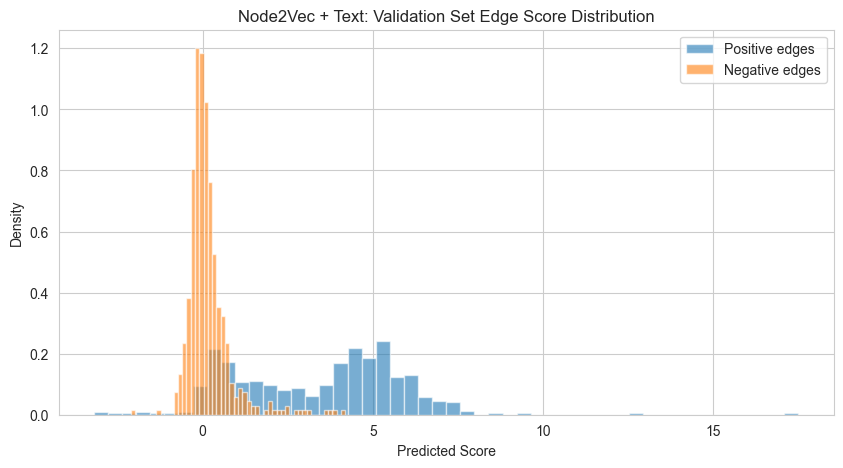


TRAINING SET Results:
  ROC-AUC: 0.9994
  Average Precision: 0.9992
  Accuracy (threshold=0.28): 0.8590
  Pos edges - Mean: 6.0793, Std: 1.0836
  Neg edges - Mean: 0.1776, Std: 0.6554
  Separation: 5.9017

VALIDATION SET Results:
  ROC-AUC: 0.9203
  Average Precision: 0.9386
  Accuracy (threshold=0.28): 0.8164
  Pos edges - Mean: 3.4118, Std: 2.3803
  Neg edges - Mean: 0.1487, Std: 0.6383
  Separation: 3.2631

TEST SET Results:
  ROC-AUC: 0.9166
  Average Precision: 0.9324
  Accuracy (threshold=0.28): 0.8100
  Pos edges - Mean: 3.4424, Std: 2.3272
  Neg edges - Mean: 0.1944, Std: 0.6939
  Separation: 3.2480

----------------------------------------------------------------------
RESULTS SUMMARY (Node2Vec + Text, Dot Product)
----------------------------------------------------------------------
        Split   ROC-AUC        AP  Accuracy
0       Train  0.999414  0.999240  0.859033
1  Validation  0.920307  0.938622  0.816421
2        Test  0.916634  0.932388  0.809963


In [41]:
# -- evaluate combined embeddings with dot product scoring
# -- reuse the evaluate() and predict_edges() functions from Method 1

print("\n" + '-' * 70)
print("NODE2VEC + TEXT EMBEDDINGS - DOT PRODUCT EVALUATION")
print('-' * 70)

# -- score distributions on validation set to choose threshold
val_pos_scores_n2v = predict_edges(combined_embeddings, val_data.pos_edge_label_index)
val_neg_scores_n2v = predict_edges(combined_embeddings, val_data.neg_edge_label_index)

plt.figure(figsize=(10, 5))
plt.hist(val_pos_scores_n2v.detach().cpu().numpy(), bins=50, alpha=0.6, label='Positive edges', density=True)
plt.hist(val_neg_scores_n2v.detach().cpu().numpy(), bins=50, alpha=0.6, label='Negative edges', density=True)
plt.xlabel('Predicted Score')
plt.ylabel('Density')
plt.title('Node2Vec + Text: Validation Set Edge Score Distribution')
plt.legend()
plt.show()

# -- evaluate on all splits
train_results_n2v = evaluate(
    combined_embeddings,
    train_data.pos_edge_label_index,
    train_data.neg_edge_label_index,
    split_name="TRAINING SET"
)

val_results_n2v = evaluate(
    combined_embeddings,
    val_data.pos_edge_label_index,
    val_data.neg_edge_label_index,
    split_name="VALIDATION SET"
)

test_results_n2v = evaluate(
    combined_embeddings,
    test_data.pos_edge_label_index,
    test_data.neg_edge_label_index,
    split_name="TEST SET"
)

results_n2v_dot_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_results_n2v['roc_auc'], val_results_n2v['roc_auc'], test_results_n2v['roc_auc']],
    'AP': [train_results_n2v['ap'], val_results_n2v['ap'], test_results_n2v['ap']],
    'Accuracy': [train_results_n2v['accuracy'], val_results_n2v['accuracy'], test_results_n2v['accuracy']],
})

print("\n" + '-' * 70)
print("RESULTS SUMMARY (Node2Vec + Text, Dot Product)")
print('-' * 70)
print(results_n2v_dot_df)

#### 3.2.3.2 Node2Vec + Text Embeddings with Logistic Regression
Similar to Method 1, we train a logistic regression classifier on edge features created by concatenating the combined embeddings of source and destination nodes. This allows the model to learn a non-trivial decision boundary beyond simple dot product similarity.

In [50]:
# -- create edge datasets using combined embeddings
print('-' * 70)
print("CREATING TABULAR DATASETS FOR LOGISTIC REGRESSION (Node2Vec + Text)")
print('-' * 70)

X_train_n2v, y_train_n2v = create_edge_dataset(
    combined_embeddings,
    train_data.pos_edge_label_index,
    train_data.neg_edge_label_index
)

X_val_n2v, y_val_n2v = create_edge_dataset(
    combined_embeddings,
    val_data.pos_edge_label_index,
    val_data.neg_edge_label_index
)

X_test_n2v, y_test_n2v = create_edge_dataset(
    combined_embeddings,
    test_data.pos_edge_label_index,
    test_data.neg_edge_label_index
)

print(f"\nDataset shapes:")
print(f"  Train: X={X_train_n2v.shape}, y={y_train_n2v.shape}")
print(f"  Val:   X={X_val_n2v.shape}, y={y_val_n2v.shape}")
print(f"  Test:  X={X_test_n2v.shape}, y={y_test_n2v.shape}")
print(f"  Feature dimension: {X_train_n2v.shape[1]} (2 x {X_train_n2v.shape[1]//2})")

# -- scale and train
scaler_n2v = StandardScaler()
X_train_n2v_scaled = scaler_n2v.fit_transform(X_train_n2v)
X_val_n2v_scaled = scaler_n2v.transform(X_val_n2v)
X_test_n2v_scaled = scaler_n2v.transform(X_test_n2v)

print("\n" + '-' * 70)
print("TRAINING LOGISTIC REGRESSION (Node2Vec + Text)")
print('-' * 70)

lr_model_n2v = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
)

lr_model_n2v.fit(X_train_n2v_scaled, y_train_n2v)

# -- evaluate
print("\n" + '-' * 70)
print("EVALUATION")
print('-' * 70)

train_lr_n2v = evaluate_lr(lr_model_n2v, X_train_n2v_scaled, y_train_n2v, scaler_n2v, "TRAINING SET")
val_lr_n2v = evaluate_lr(lr_model_n2v, X_val_n2v_scaled, y_val_n2v, scaler_n2v, "VALIDATION SET")
test_lr_n2v = evaluate_lr(lr_model_n2v, X_test_n2v_scaled, y_test_n2v, scaler_n2v, "TEST SET")

results_n2v_lr_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_lr_n2v['roc_auc'], val_lr_n2v['roc_auc'], test_lr_n2v['roc_auc']],
    'AP': [train_lr_n2v['ap'], val_lr_n2v['ap'], test_lr_n2v['ap']],
    'Accuracy': [train_lr_n2v['accuracy'], val_lr_n2v['accuracy'], test_lr_n2v['accuracy']],
})

print("\n" + '-' * 70)
print("RESULTS SUMMARY (Node2Vec + Text, Logistic Regression)")
print('-' * 70)
print(results_n2v_lr_df)

results_n2v_lr_df.to_csv("results/node2vec_text_lr_results.csv", index=False)

----------------------------------------------------------------------
CREATING TABULAR DATASETS FOR LOGISTIC REGRESSION (Node2Vec + Text)
----------------------------------------------------------------------

Dataset shapes:
  Train: X=(8690, 2304), y=(8690,)
  Val:   X=(1084, 2304), y=(1084,)
  Test:  X=(1084, 2304), y=(1084,)
  Feature dimension: 2304 (2 x 1152)

----------------------------------------------------------------------
TRAINING LOGISTIC REGRESSION (Node2Vec + Text)
----------------------------------------------------------------------

----------------------------------------------------------------------
EVALUATION
----------------------------------------------------------------------

TRAINING SET Results:
  ROC-AUC: 0.8980
  AP: 0.8979
  Accuracy: 0.8160

TRAINING SET Classification Report:
              precision    recall  f1-score   support

     No Edge       0.83      0.80      0.81      4345
        Edge       0.81      0.83      0.82      4345

    accuracy 

#### 3.2.3.3 Method Comparison: Neighbor Aggregation vs Node2Vec + Text
Let's compare the test set performance of all methods so far to understand which embedding strategy and scoring function works best for link prediction on the Cora dataset.

TEST SET COMPARISON - ALL METHODS
                         Method  ROC-AUC       AP  Accuracy
    Neighbor Agg. + Dot Product 0.955369 0.951644  0.887454
  Neighbor Agg. + Logistic Reg. 0.607246 0.564434  0.599631
  Node2Vec + Text + Dot Product 0.916634 0.932388  0.809963
Node2Vec + Text + Logistic Reg. 0.655530 0.642571  0.614391


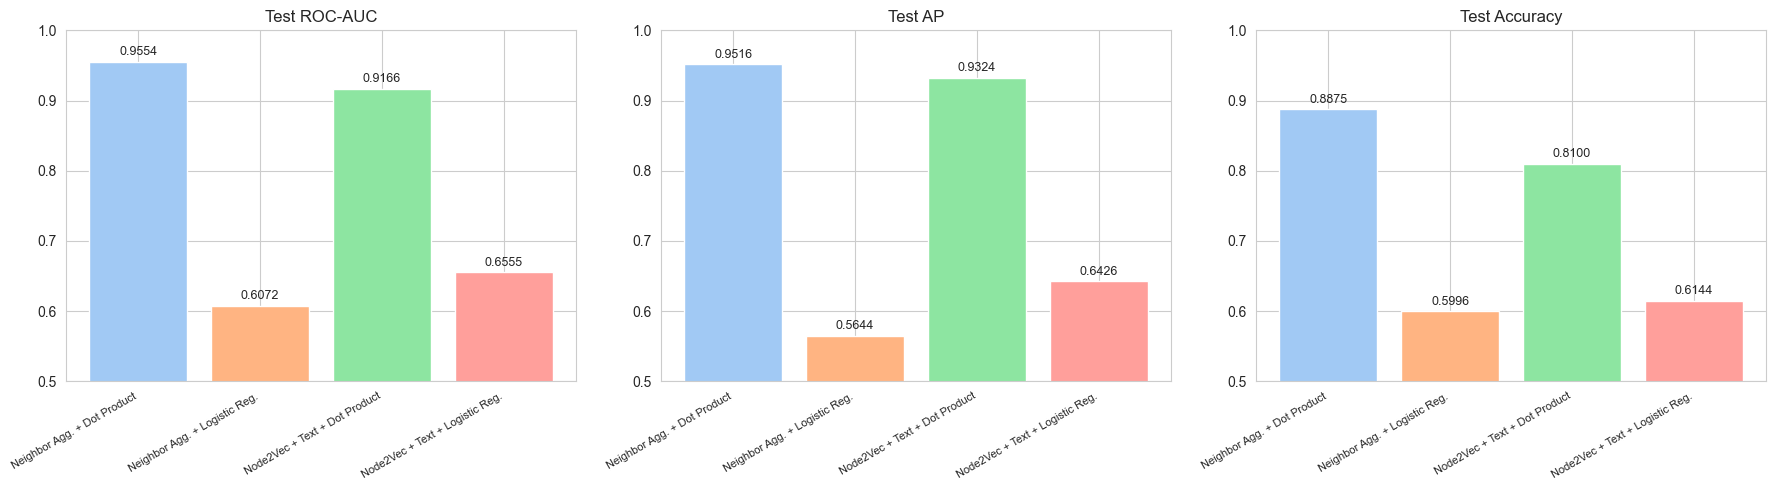

In [45]:
# -- compare all methods on test set
comparison_df = pd.DataFrame({
    'Method': [
        'Neighbor Agg. + Dot Product',
        'Neighbor Agg. + Logistic Reg.',
        'Node2Vec + Text + Dot Product',
        'Node2Vec + Text + Logistic Reg.',
    ],
    'ROC-AUC': [
        test_results['roc_auc'],
        test_lr_results['roc_auc'],
        test_results_n2v['roc_auc'],
        test_lr_n2v['roc_auc'],
    ],
    'AP': [
        test_results['ap'],
        test_lr_results['ap'],
        test_results_n2v['ap'],
        test_lr_n2v['ap'],
    ],
    'Accuracy': [
        test_results['accuracy'],
        test_lr_results['accuracy'],
        test_results_n2v['accuracy'],
        test_lr_n2v['accuracy'],
    ],
})

print("=" * 70)
print("TEST SET COMPARISON - ALL METHODS")
print("=" * 70)
print(comparison_df.to_string(index=False))

# -- bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['ROC-AUC', 'AP', 'Accuracy']
colors_bar = sns.color_palette("pastel", 4)

for i, metric in enumerate(metrics):
    bars = axes[i].bar(range(len(comparison_df)), comparison_df[metric], color=colors_bar)
    axes[i].set_title(f'Test {metric}')
    axes[i].set_xticks(range(len(comparison_df)))
    axes[i].set_xticklabels(comparison_df['Method'], rotation=30, ha='right', fontsize=8)
    axes[i].set_ylim(0.5, 1.0)
    for bar, val in zip(bars, comparison_df[metric]):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

comparison_df.to_csv("results/method_comparison.csv", index=False)

### 3.2.4 Method 3 : Graphe Convolutional Network (GCN)